<a href="https://colab.research.google.com/github/alyahoang99/Movies-RS-/blob/main/RecommendationMovies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## for data
import pandas as pd
import numpy as np
import re
from datetime import datetime

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for machine learning
from sklearn import metrics, preprocessing

## for deep learning
from tensorflow.keras import models, layers, utils  #(2.6.0)

In the product table, every row represents an item and the two columns on the right contain its features, which are static.

Every row of this other table is a pair of user-product and shows the rating that users have given to products, which is the target variable.

In [ ]:
# Products
dtf_products = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/data_movies.xlsx", sheet_name="products")

dtf_products = dtf_products[~dtf_products["genres"].isna()]
dtf_products["product"] = range(0,len(dtf_products))
dtf_products["name"] = dtf_products["title"].apply(lambda x: re.sub("[\(\[].*?[\)\]]", "", x).strip())
dtf_products["year"] = dtf_products["title"].apply(lambda x: int(x.split("(")[-1].replace(")","").strip())
                                                             if "(" in x else np.nan)

## add features
dtf_products["year"] = dtf_products['year'].fillna(9999)
dtf_products["old"] = dtf_products["year"].apply(lambda x: 1 if x < 2000 else 0)

dtf_products



,movieId,title,genres,product,name,year,old
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,Toy Story,1995.0,1
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,Jumanji,1995.0,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2,Grumpier Old Men,1995.0,1
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3,Waiting to Exhale,1995.0,1
4,5,Father of the Bride Part II (1995),Comedy,4,Father of the Bride Part II,1995.0,1
...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,9736,Black Butler: Book of the Atlantic,2017.0,0
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,9737,No Game No Life: Zero,2017.0,0
9739,193585,Flint (2017),Drama,9738,Flint,2017.0,0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,9739,Bungo Stray Dogs: Dead Apple,2018.0,0


Extract 2 context variables from the timestamp column daytime and weekend

In [ ]:
# Users
dtf_users = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/data_movies.xlsx", sheet_name="users").head(10000)

dtf_users["user"] = dtf_users["userId"].apply(lambda x: x-1)

dtf_users["timestamp"] = dtf_users["timestamp"].apply(lambda x: datetime.fromtimestamp(x))
dtf_users["daytime"] = dtf_users["timestamp"].apply(lambda x: 1 if 6<int(x.strftime("%H"))<20 else 0)
dtf_users["weekend"] = dtf_users["timestamp"].apply(lambda x: 1 if x.weekday() in [5,6] else 0)

dtf_users = dtf_users.merge(dtf_products[["movieId","product"]], how="left")
dtf_users = dtf_users.rename(columns={"rating":"y"})

dtf_users

,userId,movieId,y,timestamp,user,daytime,weekend,product
0,1,1,4.0,2000-07-30 18:45:03,0,1,1,0
1,1,3,4.0,2000-07-30 18:20:47,0,1,1,2
2,1,6,4.0,2000-07-30 18:37:04,0,1,1,5
3,1,47,5.0,2000-07-30 19:03:35,0,1,1,43
4,1,50,5.0,2000-07-30 18:48:51,0,1,1,46
...,...,...,...,...,...,...,...,...
9995,66,248,3.0,2005-04-11 03:41:32,65,0,0,212
9996,66,255,0.5,2005-04-11 03:07:20,65,0,0,219
9997,66,260,2.5,2004-08-29 02:45:50,65,0,1,224
9998,66,272,3.5,2005-04-11 03:31:59,65,0,0,234


In [ ]:
# select only useful columns
dtf_products = dtf_products[["product","name","old","genres"]].set_index("product")
dtf_products.head()

,name,old,genres
product,,,
0,Toy Story,1,Adventure|Animation|Children|Comedy|Fantasy
1,Jumanji,1,Adventure|Children|Fantasy
2,Grumpier Old Men,1,Comedy|Romance
3,Waiting to Exhale,1,Comedy|Drama|Romance
4,Father of the Bride Part II,1,Comedy


In [ ]:
# extract context
dtf_context = dtf_users[["user","product","daytime","weekend"]]
dtf_context.head()

,user,product,daytime,weekend
0,0,0,1,1
1,0,2,1,1
2,0,5,1,1
3,0,43,1,1
4,0,46,1,1


In [ ]:
dtf_users = dtf_users[["user","product","y"]]
dtf_users.head()

,user,product,y
0,0,0,4.0
1,0,2,4.0
2,0,5,4.0
3,0,43,5.0
4,0,46,5.0


In [ ]:
tags = [i.split("|") for i in dtf_products["genres"].unique()]
columns = list(set([i for lst in tags for i in lst]))
columns.remove('(no genres listed)')
print(columns)

['Western', 'Animation', 'Action', 'Thriller', 'Fantasy', 'Adventure', 'Horror', 'War', 'Film-Noir', 'IMAX', 'Sci-Fi', 'Musical', 'Crime', 'Romance', 'Drama', 'Mystery', 'Documentary', 'Comedy', 'Children']


In [ ]:
for col in columns:
    dtf_products[col] = dtf_products["genres"].apply(lambda x: 1 if col in x else 0)
dtf_products.head()

,name,old,genres,Western,Animation,Action,Thriller,Fantasy,Adventure,Horror,...,IMAX,Sci-Fi,Musical,Crime,Romance,Drama,Mystery,Documentary,Comedy,Children
product,,,,,,,,,,,,,,,,,,,,,
0,Toy Story,1,Adventure|Animation|Children|Comedy|Fantasy,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,1
1,Jumanji,1,Adventure|Children|Fantasy,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
2,Grumpier Old Men,1,Comedy|Romance,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,Waiting to Exhale,1,Comedy|Drama|Romance,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,1,0
4,Father of the Bride Part II,1,Comedy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


The matrix is sparse as most of the products dont have all the features. Let's visualise it to understand better the situation.

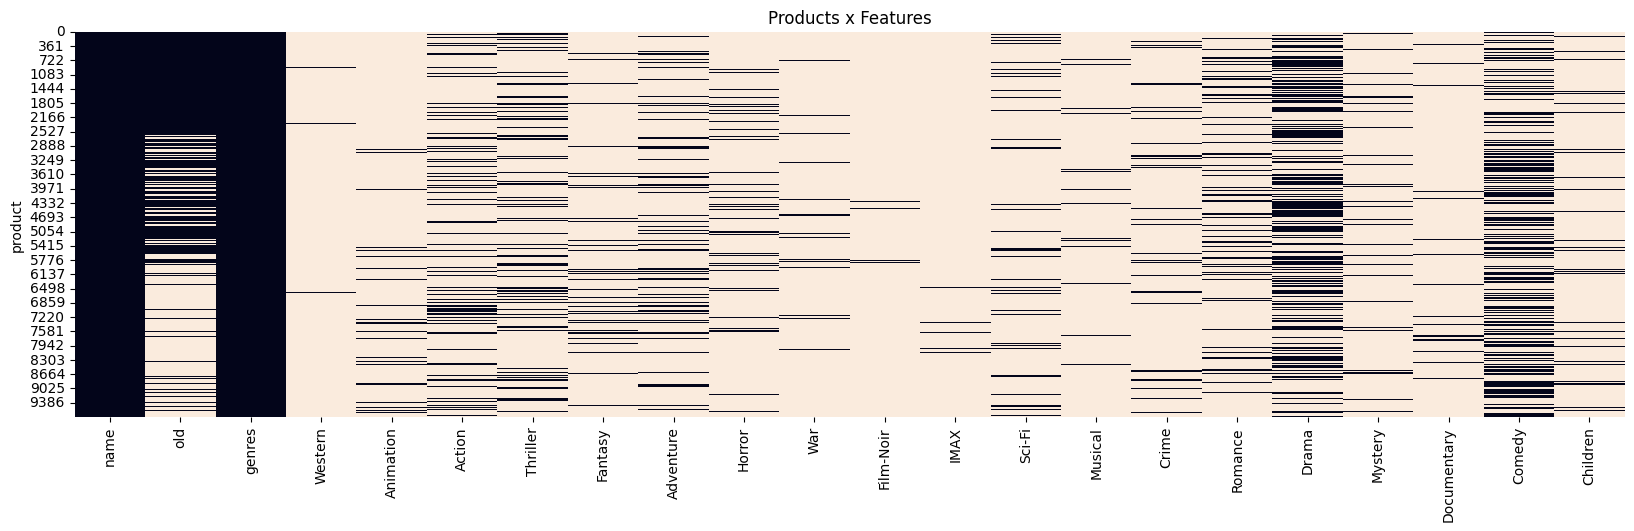

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(dtf_products==0, vmin=0, vmax=1, cbar=False, ax=ax).set_title("Products x Features")
plt.show()

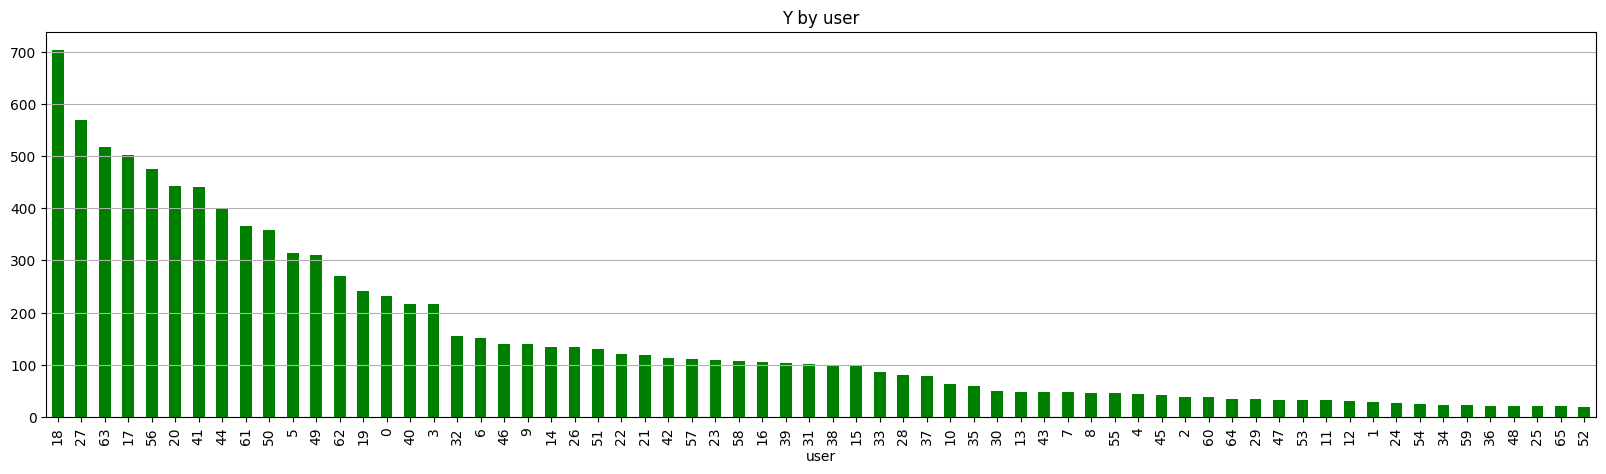

In [ ]:
# user
dtf_users.groupby("user").count()["product"].sort_values(ascending=False).plot(
    kind="bar", color="green", title="Y by user", figsize=(20,5)).grid(axis='y')

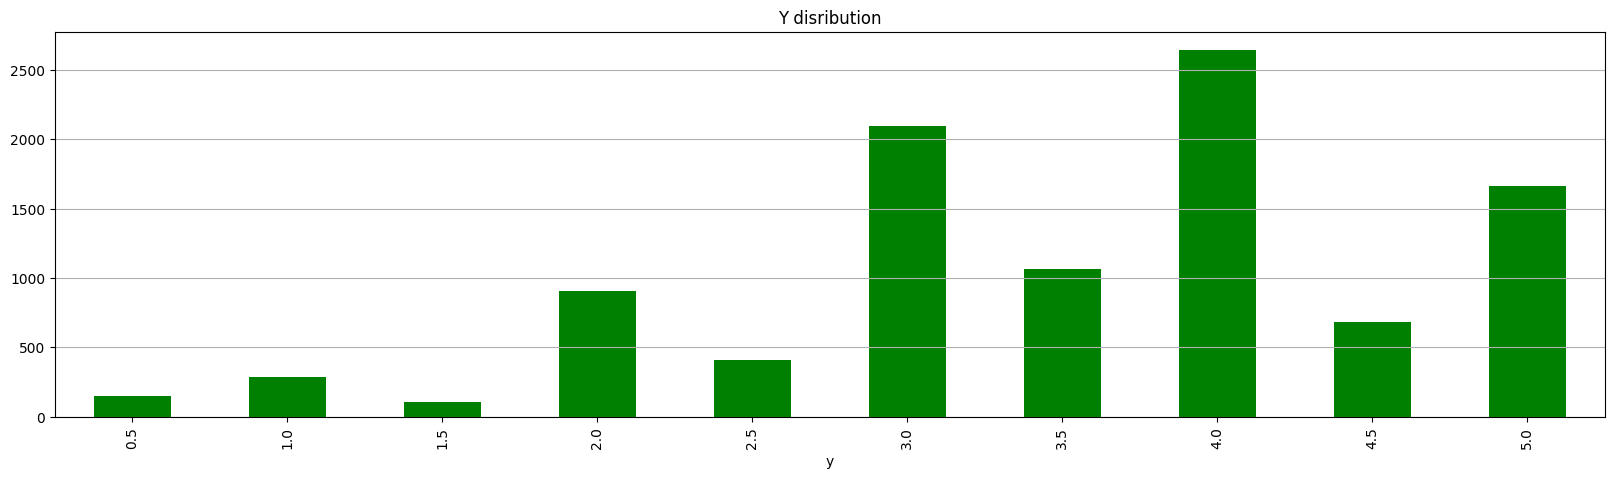

In [ ]:
dtf_users["y"].value_counts().sort_index().plot(kind="bar", color="green", title="Y disribution",
                                                figsize=(20,5)).grid(axis='y')
plt.show()

In [ ]:
tmp = dtf_users.copy()
dtf_users = tmp.pivot_table(index="user", columns="product", values="y")
missing_cols = list(set(dtf_products.index) - set(dtf_users.columns))
for col in missing_cols:
    dtf_users[col] = np.nan
dtf_users = dtf_users[sorted(dtf_users.columns)]
dtf_users

product,0,1,2,3,4,5,6,7,8,9,...,9731,9732,9733,9734,9735,9736,9737,9738,9739,9740
user,,,,,,,,,,,,,,,,,,,,,
0,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,NaN,4.0,NaN,NaN,NaN,4.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,4.0,NaN,3.5,NaN,NaN,4.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


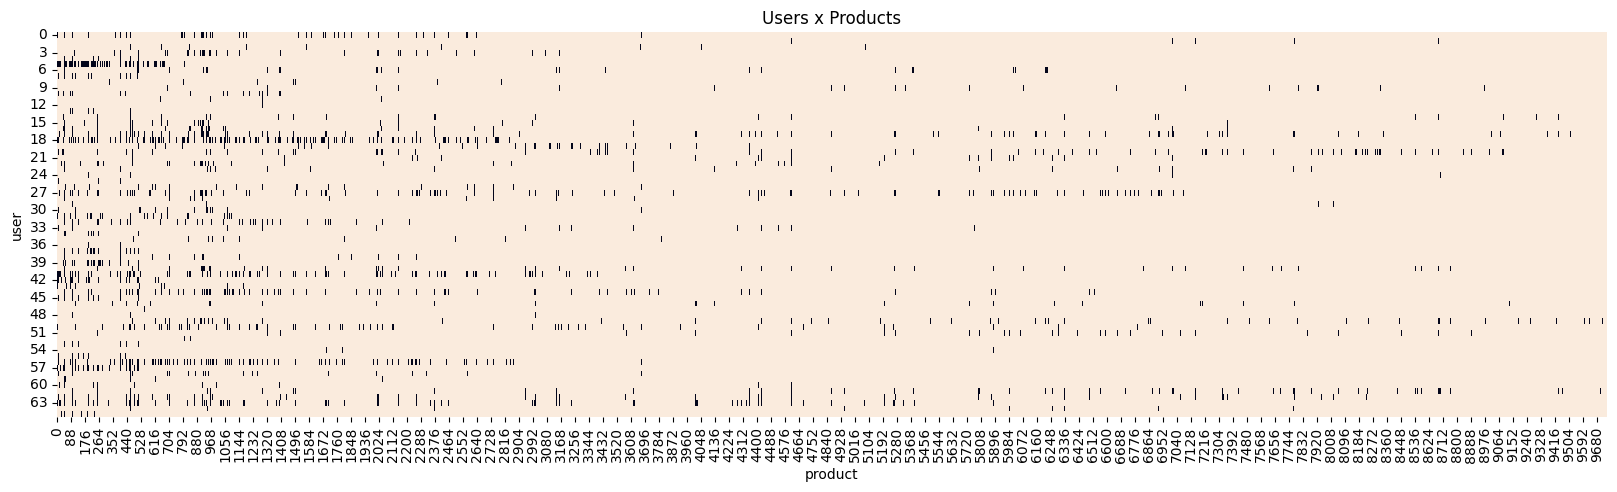

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(dtf_users.isnull(), vmin=0, vmax=1, cbar=False, ax=ax).set_title("Users x Products")
plt.show()

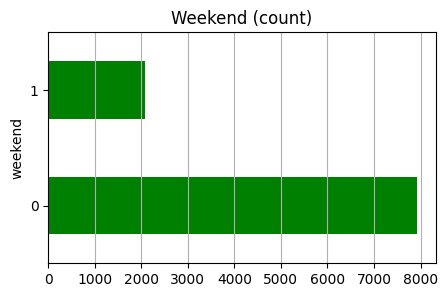

In [ ]:
# context
dtf_context["weekend"].value_counts().plot(kind="barh", color="green", title="Weekend (count)",
                                         figsize=(5,3)).grid(axis='x')
plt.show()

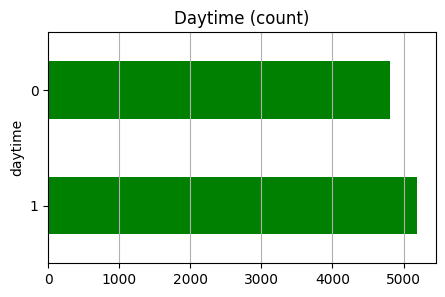

In [ ]:
dtf_context["daytime"].value_counts().plot(kind="barh", color="green", title="Daytime (count)",
                                         figsize=(5,3)).grid(axis='x')
plt.show()

In [ ]:
# scaling
dtf_users = pd.DataFrame(preprocessing.MinMaxScaler(feature_range=(0.5,1)).fit_transform(dtf_users.values),
                         columns=dtf_users.columns, index=dtf_users.index)
dtf_users

product,0,1,2,3,4,5,6,7,8,9,...,9731,9732,9733,9734,9735,9736,9737,9738,9739,9740
user,,,,,,,,,,,,,,,,,,,,,
0,0.8,NaN,0.750,NaN,NaN,0.750,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,NaN,0.833333,NaN,NaN,NaN,0.875,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,0.8,NaN,0.625,NaN,NaN,0.875,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# partitioning
split = int(0.8*dtf_users.shape[1])
split

7792

In [ ]:
# train
dtf_train = dtf_users.loc[:, :split-1]
print("non-null data:", dtf_train[dtf_train>0].count().sum())
dtf_train

non-null data: 9329


product,0,1,2,3,4,5,6,7,8,9,...,7782,7783,7784,7785,7786,7787,7788,7789,7790,7791
user,,,,,,,,,,,,,,,,,,,,,
0,0.8,NaN,0.750,NaN,NaN,0.750,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,NaN,0.833333,NaN,NaN,NaN,0.875,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,0.8,NaN,0.625,NaN,NaN,0.875,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Test
dtf_test = dtf_users.loc[:, split:]
print("non-null data:", dtf_test[dtf_test>0].count().sum())
dtf_test

non-null data: 671


product,7792,7793,7794,7795,7796,7797,7798,7799,7800,7801,...,9731,9732,9733,9734,9735,9736,9737,9738,9739,9740
user,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Baseline (content-based)

This method is based on the product contents. Two products are similar if they have similar features. Let's pick one user from the data as an example of our first subscriber that has now used enough products, and let's create the train and vectors.

In [ ]:
# Select a user
i = 1
train = dtf_train.iloc[i].to_frame(name="y")
test = dtf_test.iloc[i].to_frame(name="y")

print("train:", len(train[~train["y"].isna()]), "| test:", len(test[~test["y"].isna()]))
test.head()

train: 21 | test: 8


,y
product,
7792,NaN
7793,NaN
7794,NaN
7795,NaN
7796,NaN


In [ ]:
# add all products in test but empty
tmp = test.copy()
tmp["y"] = np.nan
train = pd.concat([train, tmp])
train.tail()

,y
product,
9736,NaN
9737,NaN
9738,NaN
9739,NaN
9740,NaN


Need to estimate the weights that the user gives to each feature. We have the User-Products vector and the Products-Features matrix

In [ ]:
# Model
usr = train[["y"]].fillna(0).values.T
prd = dtf_products.drop(["name","genres"],axis=1).values
print("Users", usr.shape, " x  Products", prd.shape)

Users (1, 9741)  x  Products (9741, 20)


In [ ]:
# Numpy
import numpy as np

## usr_ft(users,fatures) = usr(users,products) x prd(products,features)
usr_ft = np.dot(usr, prd)
## normalize
weights = usr_ft / usr_ft.sum()
## predicted rating(users,products) = weights(users,fatures) x prd.T(features,products)
pred = np.dot(weights, prd.T)

test = test.merge(pd.DataFrame(pred[0], columns=["yhat"]), how="left", left_index=True, right_index=True).reset_index()
test = test[~test["y"].isna()]
test

,product,y,yhat
271,8063,0.812500,0.364068
513,8305,1.000000,0.441084
584,8376,0.777778,0.077697
674,8466,0.800000,0.215465
717,8509,0.500000,0.477922
758,8550,0.875000,0.356925
889,8681,1.000000,0.327055
1036,8828,0.500000,0.033233


In [ ]:
# Evaluate
def mean_reciprocal_rank(y_test, predicted):
    score = []
    for product in y_test:
        mrr = 1 / (list(predicted).index(product) + 1) if product in predicted else 0
        score.append(mrr)
    return np.mean(score)

In [ ]:
print("--- user", i, "---")

top = 5
y_test = test.sort_values("y", ascending=False)["product"].values[:top]
print("y_test:", y_test)

predicted = test.sort_values("yhat", ascending=False)["product"].values[:top]
print("predicted:", predicted)

true_positive = len(list(set(y_test) & set(predicted)))
print("true positive:", true_positive, "("+str(round(true_positive/top*100,1))+"%)")
print("accuracy:", str(round(metrics.accuracy_score(y_test,predicted)*100,1))+"%")
print("mrr:", round(mean_reciprocal_rank(y_test, predicted),2))

--- user 1 ---
y_test: [8305 8681 8550 8063 8466]
predicted: [8509 8305 8063 8550 8681]
true positive: 4 (80.0%)
accuracy: 0.0%
mrr: 0.26


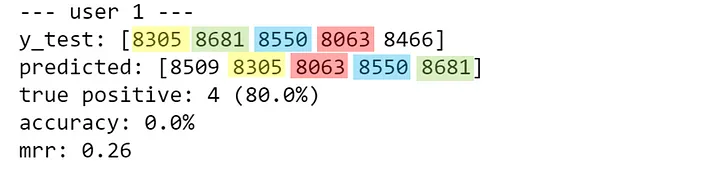
Accuracy and MRR is low since the order is not correct

In [ ]:
test.merge(
        dtf_products[["name","old","genres"]], left_on="product", right_index=True
    ).sort_values("yhat", ascending=False)

,product,y,yhat,name,old,genres
717,8509,0.500000,0.477922,The Drop,0,Crime|Drama|Thriller
513,8305,1.000000,0.441084,"Wolf of Wall Street, The",0,Comedy|Crime|Drama
271,8063,0.812500,0.364068,Django Unchained,0,Action|Drama|Western
758,8550,0.875000,0.356925,Ex Machina,0,Drama|Sci-Fi|Thriller
889,8681,1.000000,0.327055,Mad Max: Fury Road,0,Action|Adventure|Sci-Fi|Thriller
674,8466,0.800000,0.215465,Whiplash,0,Drama
584,8376,0.777778,0.077697,Interstellar,0,Sci-Fi|IMAX
1036,8828,0.500000,0.033233,The Jinx: The Life and Deaths of Robert Durst,0,Documentary


## Collaborative Fitlering

This method does not need product features to work, it requires many ratings from many users instead.

In [ ]:
# data
train = dtf_train.stack(dropna=True).reset_index().rename(columns={0:"y"})
train.head()

,user,product,y
0,0,0,0.80
1,0,2,0.75
2,0,5,0.75
3,0,43,1.00
4,0,46,1.00


In [ ]:
test = dtf_test.stack(dropna=True).reset_index().rename(columns={0:"y"})
test.head()

,user,product,y
0,1,8063,0.812500
1,1,8305,1.000000
2,1,8376,0.777778
3,1,8466,0.800000
4,1,8509,0.500000


The main idea is to leverage the Embedding layer of a Neural Network to create the Users and Products matrices. It's important to understand the the inputs are user-product pairs and the output is the rating. When predicting a new pair of user-product, the model is going to lookup the user in the Users embedding space and the product in the Products space. For that reason, you need to specify in advance the total number of users and products.

In [ ]:
# model design
embeddings_size = 50
usr, prd = dtf_users.shape[0], dtf_users.shape[1]

# Users (,1,embedding_size) and Reshape (,embedding_size)
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xusers_emb = layers.Embedding(name="xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
xusers = layers.Reshape(name='xusers', target_shape=(embeddings_size,))(xusers_emb)

# Products (,1,embedding_size) and Reshape (,embedding_size)
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))
xproducts_emb = layers.Embedding(name="xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
xproducts = layers.Reshape(name='xproducts', target_shape=(embeddings_size,))(xproducts_emb)

# Product (,1) values[-1,1]
xx = layers.Dot(name='xx', normalize=True, axes=1)([xusers, xproducts])

# Predict ratings (,1)
y_out = layers.Dense(name="y_out", units=1, activation='linear')(xx)

# Compile
model = models.Model(inputs=[xusers_in,xproducts_in], outputs=y_out, name="CollaborativeFiltering")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
model.summary()

Model: "CollaborativeFiltering"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ xusers_in (InputLayer)    │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ xproducts_in (InputLayer) │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ xusers_emb (Embedding)    │ (None, 1, 50)          │          3,300 │ xusers_in[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ xproducts_emb (Embedding) │ (None, 1, 50)          │        487,050 │ xproducts_in[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ xusers (Reshape)          │ (None, 50)             │              0 │ xusers_emb[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ xproducts (Reshape)       │ (None, 50)             │              0 │ xproducts_emb[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ xx (Dot)                  │ (None, 1)              │              0 │ xusers[0][0],          │
│                           │                        │                │ xproducts[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ y_out (Dense)             │ (None, 1)              │              2 │ xx[0][0]               │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 490,352 (1.87 MB)

 Trainable params: 490,352 (1.87 MB)

 Non-trainable params: 0 (0.00 B)

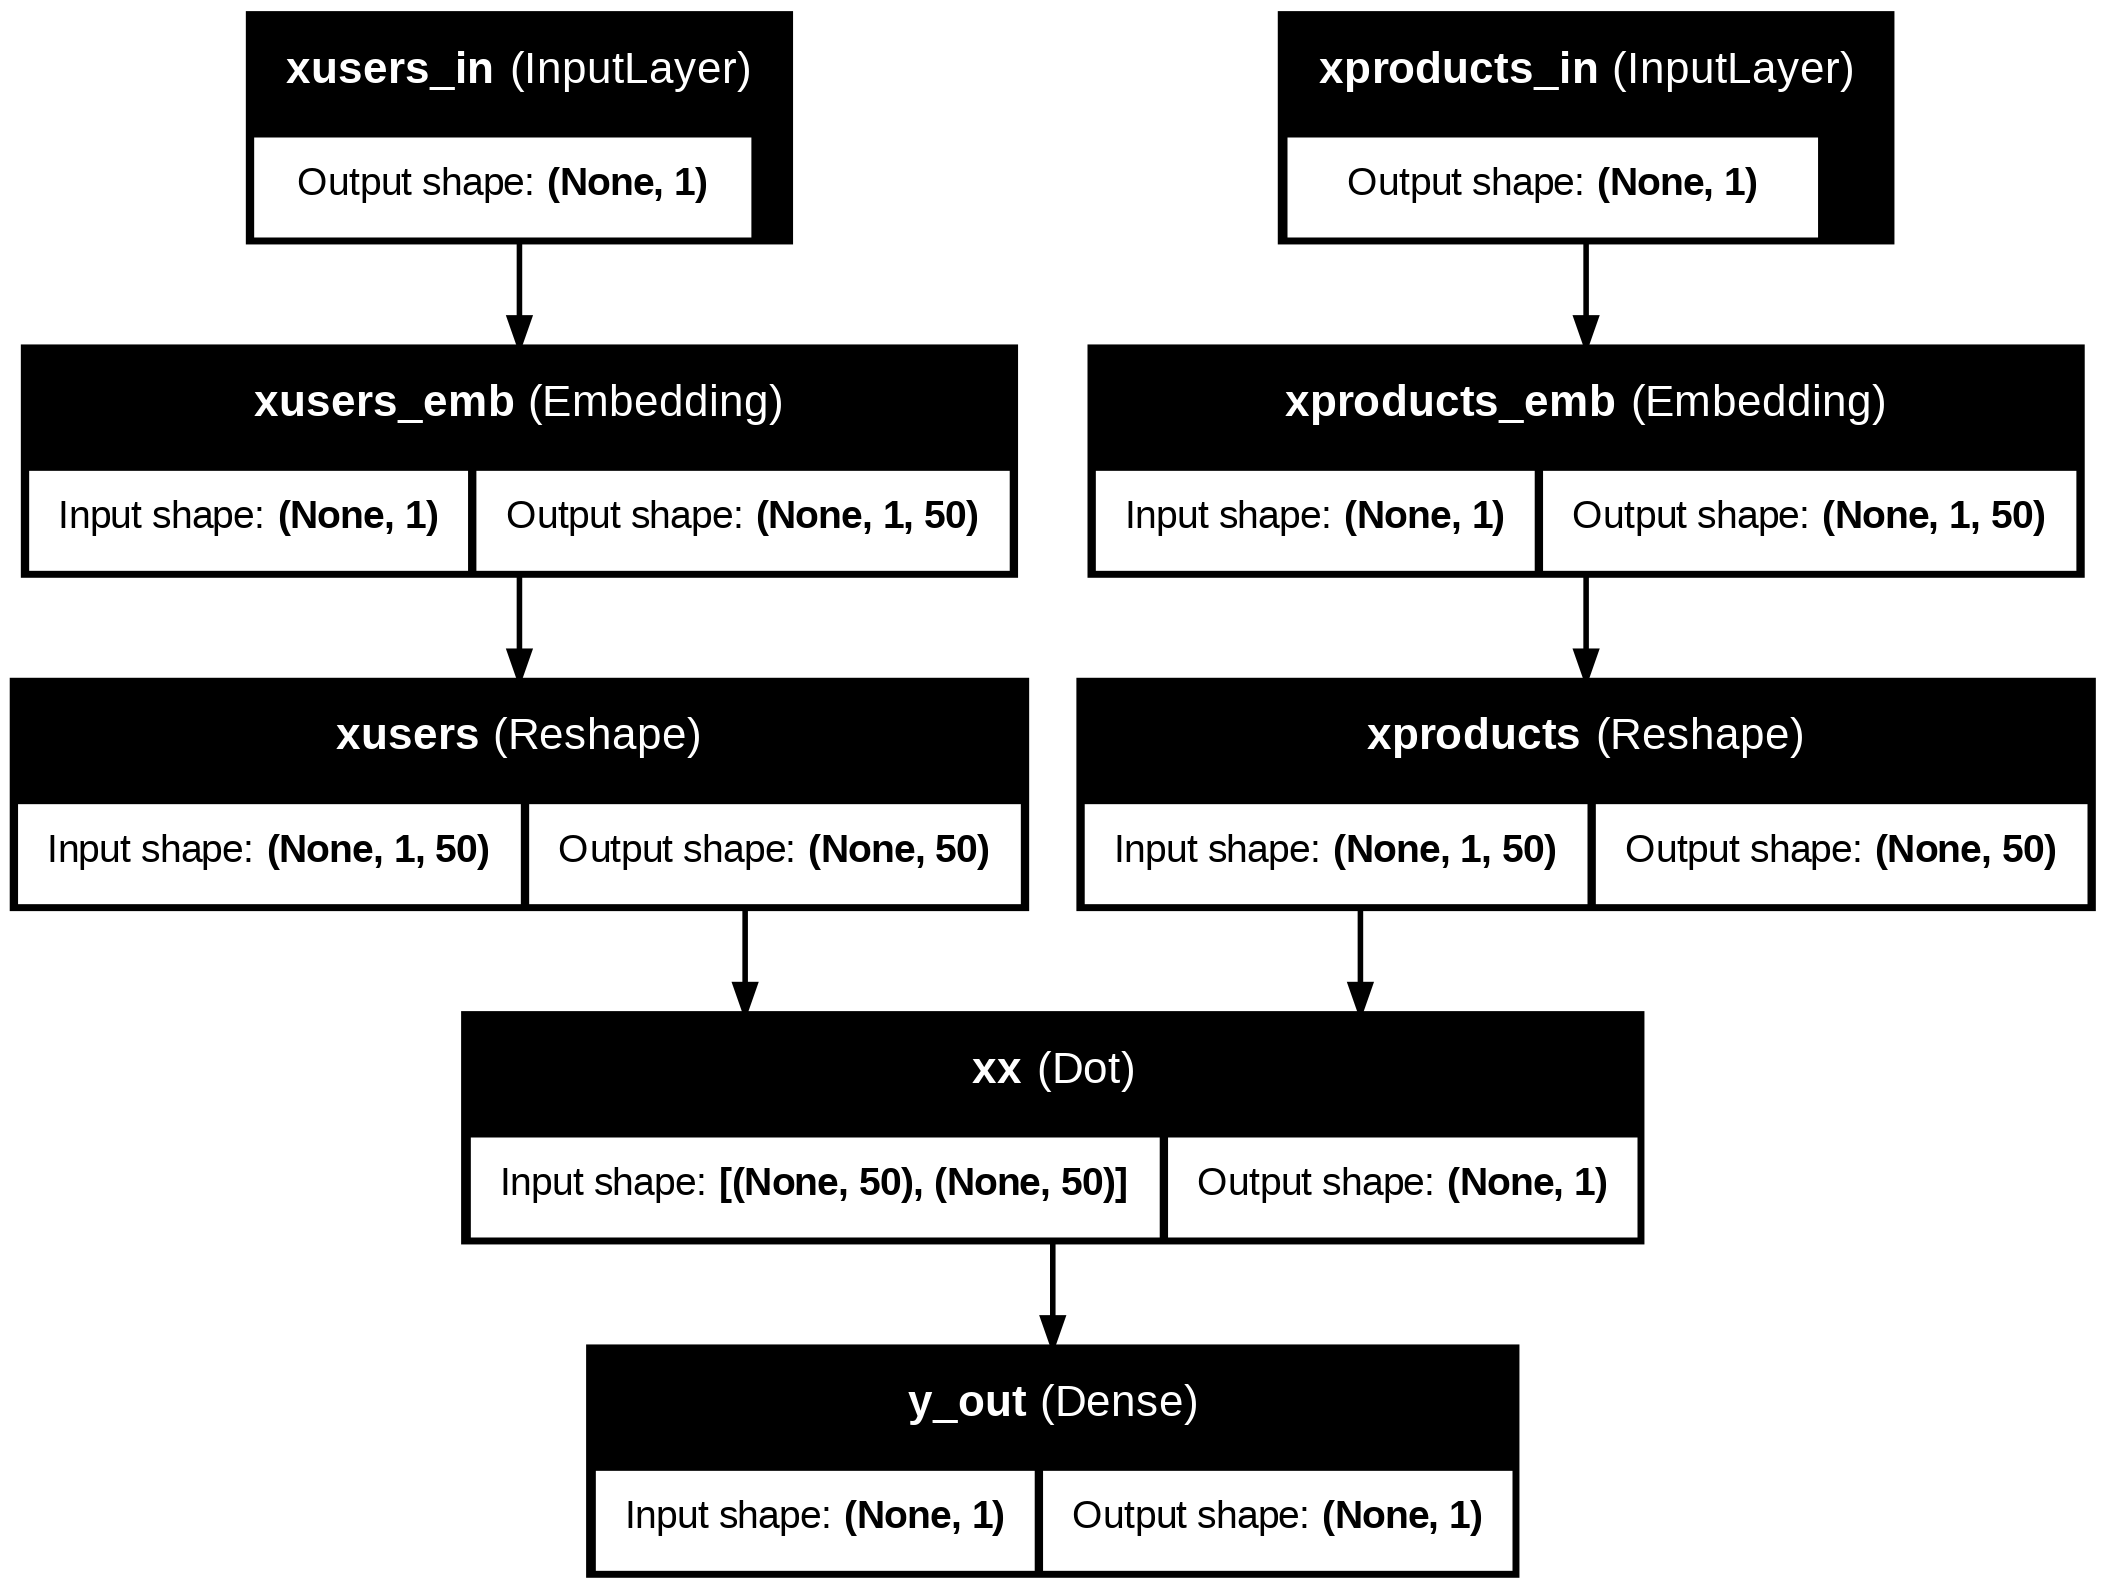

In [ ]:
utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# train
'''
Plot loss and metrics of keras training.
'''
def utils_plot_keras_training(training):
    metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))

    ## training
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    ax[0].plot(training.history['loss'], color='black')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()

    ## validation
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    ax[1].plot(training.history['val_loss'], color='black')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax22.plot(training.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
    plt.show()

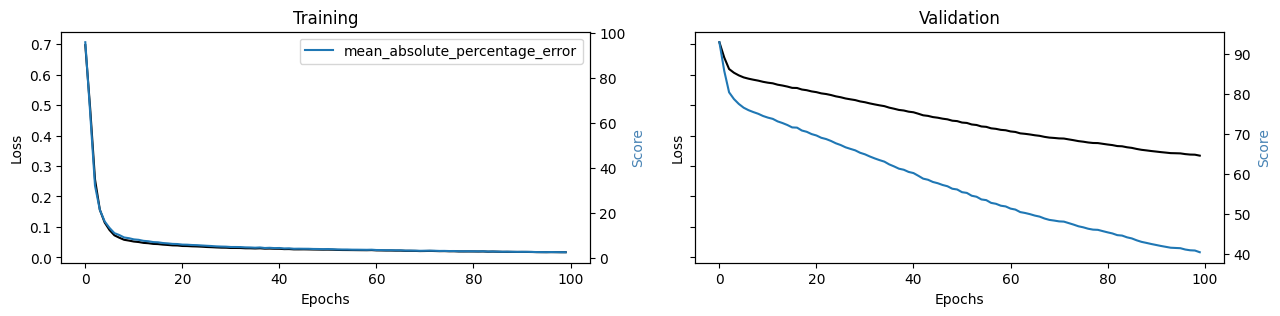

In [ ]:
# train
training = model.fit(x=[train["user"], train["product"]], y=train["y"],
                     epochs=100, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)
model = training.model
utils_plot_keras_training(training)

In [ ]:
# test
test["yhat"] = model.predict([test["user"], test["product"]])
test

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


,user,product,y,yhat
0,1,8063,0.812500,0.308846
1,1,8305,1.000000,0.367274
2,1,8376,0.777778,0.527019
3,1,8466,0.800000,0.308681
4,1,8509,0.500000,0.351101
...,...,...,...,...
666,64,8023,0.500000,0.564969
667,64,8376,0.944444,0.276313
668,64,8438,0.666667,0.234410
669,64,8569,0.900000,0.417341


In [ ]:
# overall
y_test = test["y"]
predicted = test["yhat"]

print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", str(round(np.mean(np.abs((y_test-predicted)/predicted)), 2))+"%")

Mean Absolute Error (Σ|y-pred|/n): 0
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.69%


In [ ]:
# single case
i = 1
print("--- user", i, "---")

top = 5
y_test = test[test["user"]==i].sort_values("y", ascending=False)["product"].values[:top]
print("y_test:", y_test)

predicted = test[test["user"]==i].sort_values("yhat", ascending=False)["product"].values[:top]
print("predicted:", predicted)

true_positive = len(list(set(y_test) & set(predicted)))
print("true positive:", true_positive, "("+str(round(true_positive/top*100,1))+"%)")
print("accuracy:", str(round(metrics.accuracy_score(y_test,predicted)*100,1))+"%")
print("mrr:", round(mean_reciprocal_rank(y_test, predicted),2))

--- user 1 ---
y_test: [8305 8681 8550 8063 8466]
predicted: [8828 8376 8305 8509 8681]
true positive: 2 (40.0%)
accuracy: 0.0%
mrr: 0.11


In [ ]:
test[test["user"]==i].merge(
        dtf_products[["name","old","genres"]], left_on="product", right_index=True
    ).sort_values("yhat", ascending=False)

,user,product,y,yhat,name,old,genres
7,1,8828,0.500000,0.647013,The Jinx: The Life and Deaths of Robert Durst,0,Documentary
2,1,8376,0.777778,0.527019,Interstellar,0,Sci-Fi|IMAX
1,1,8305,1.000000,0.367274,"Wolf of Wall Street, The",0,Comedy|Crime|Drama
4,1,8509,0.500000,0.351101,The Drop,0,Crime|Drama|Thriller
6,1,8681,1.000000,0.349485,Mad Max: Fury Road,0,Action|Adventure|Sci-Fi|Thriller
5,1,8550,0.875000,0.345963,Ex Machina,0,Drama|Sci-Fi|Thriller
0,1,8063,0.812500,0.308846,Django Unchained,0,Action|Drama|Western
3,1,8466,0.800000,0.308681,Whiplash,0,Drama


## Neural Collaborative Filtering

In [ ]:
# data
train = dtf_train.stack(dropna=True).reset_index().rename(columns={0:"y"})
train.head()

,user,product,y
0,0,0,0.80
1,0,2,0.75
2,0,5,0.75
3,0,43,1.00
4,0,46,1.00


In [ ]:
test = dtf_test.stack(dropna=True).reset_index().rename(columns={0:"y"})
test.head()

,user,product,y
0,1,8063,0.812500
1,1,8305,1.000000
2,1,8376,0.777778
3,1,8466,0.800000
4,1,8509,0.500000


In [ ]:
# model design
embeddings_size = 50
usr, prd = dtf_users.shape[0], dtf_users.shape[1]

# Input layer
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))

# A) Matrix Factorization
## embeddings and reshape
cf_xusers_emb = layers.Embedding(name="cf_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
cf_xusers = layers.Reshape(name='cf_xusers', target_shape=(embeddings_size,))(cf_xusers_emb)
## embeddings and reshape
cf_xproducts_emb = layers.Embedding(name="cf_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
cf_xproducts = layers.Reshape(name='cf_xproducts', target_shape=(embeddings_size,))(cf_xproducts_emb)
## product
cf_xx = layers.Dot(name='cf_xx', normalize=True, axes=1)([cf_xusers, cf_xproducts])

# B) Neural Network
## embeddings and reshape
nn_xusers_emb = layers.Embedding(name="nn_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
nn_xusers = layers.Reshape(name='nn_xusers', target_shape=(embeddings_size,))(nn_xusers_emb)
## embeddings and reshape
nn_xproducts_emb = layers.Embedding(name="nn_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
nn_xproducts = layers.Reshape(name='nn_xproducts', target_shape=(embeddings_size,))(nn_xproducts_emb)
## concat and dense
nn_xx = layers.Concatenate()([nn_xusers, nn_xproducts])
nn_xx = layers.Dense(name="nn_xx", units=int(embeddings_size/2), activation='relu')(nn_xx)

# Merge A & B
y_out = layers.Concatenate()([cf_xx, nn_xx])
y_out = layers.Dense(name="y_out", units=1, activation='linear')(y_out)

# Compile
model = models.Model(inputs=[xusers_in,xproducts_in], outputs=y_out, name="Neural_CollaborativeFiltering")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
model.summary()

Model: "Neural_CollaborativeFiltering"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ xusers_in (InputLayer)    │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ xproducts_in (InputLayer) │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ nn_xusers_emb (Embedding) │ (None, 1, 50)          │          3,300 │ xusers_in[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ nn_xproducts_emb          │ (None, 1, 50)          │        487,050 │ xproducts_in[0][0]     │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cf_xusers_emb (Embedding) │ (None, 1, 50)          │          3,300 │ xusers_in[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cf_xproducts_emb          │ (None, 1, 50)          │        487,050 │ xproducts_in[0][0]     │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ nn_xusers (Reshape)       │ (None, 50)             │              0 │ nn_xusers_emb[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ nn_xproducts (Reshape)    │ (None, 50)             │              0 │ nn_xproducts_emb[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cf_xusers (Reshape)       │ (None, 50)             │              0 │ cf_xusers_emb[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cf_xproducts (Reshape)    │ (None, 50)             │              0 │ cf_xproducts_emb[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 100)            │              0 │ nn_xusers[0][0],       │
│                           │                        │                │ nn_xproducts[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cf_xx (Dot)               │ (None, 1)              │              0 │ cf_xusers[0][0],       │
│                           │                        │                │ cf_xproducts[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ nn_xx (Dense)             │ (None, 25)             │          2,525 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 26)             │              0 │ cf_xx[0][0],           │
│ (Concatenate)             │                        │                │ nn_xx[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ y_out (Dense)             │ (None, 1)              │             27 │ concatenate_1[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 983,252 (3.75 MB)

 Trainable params: 983,252 (3.75 MB)

 Non-trainable params: 0 (0.00 B)

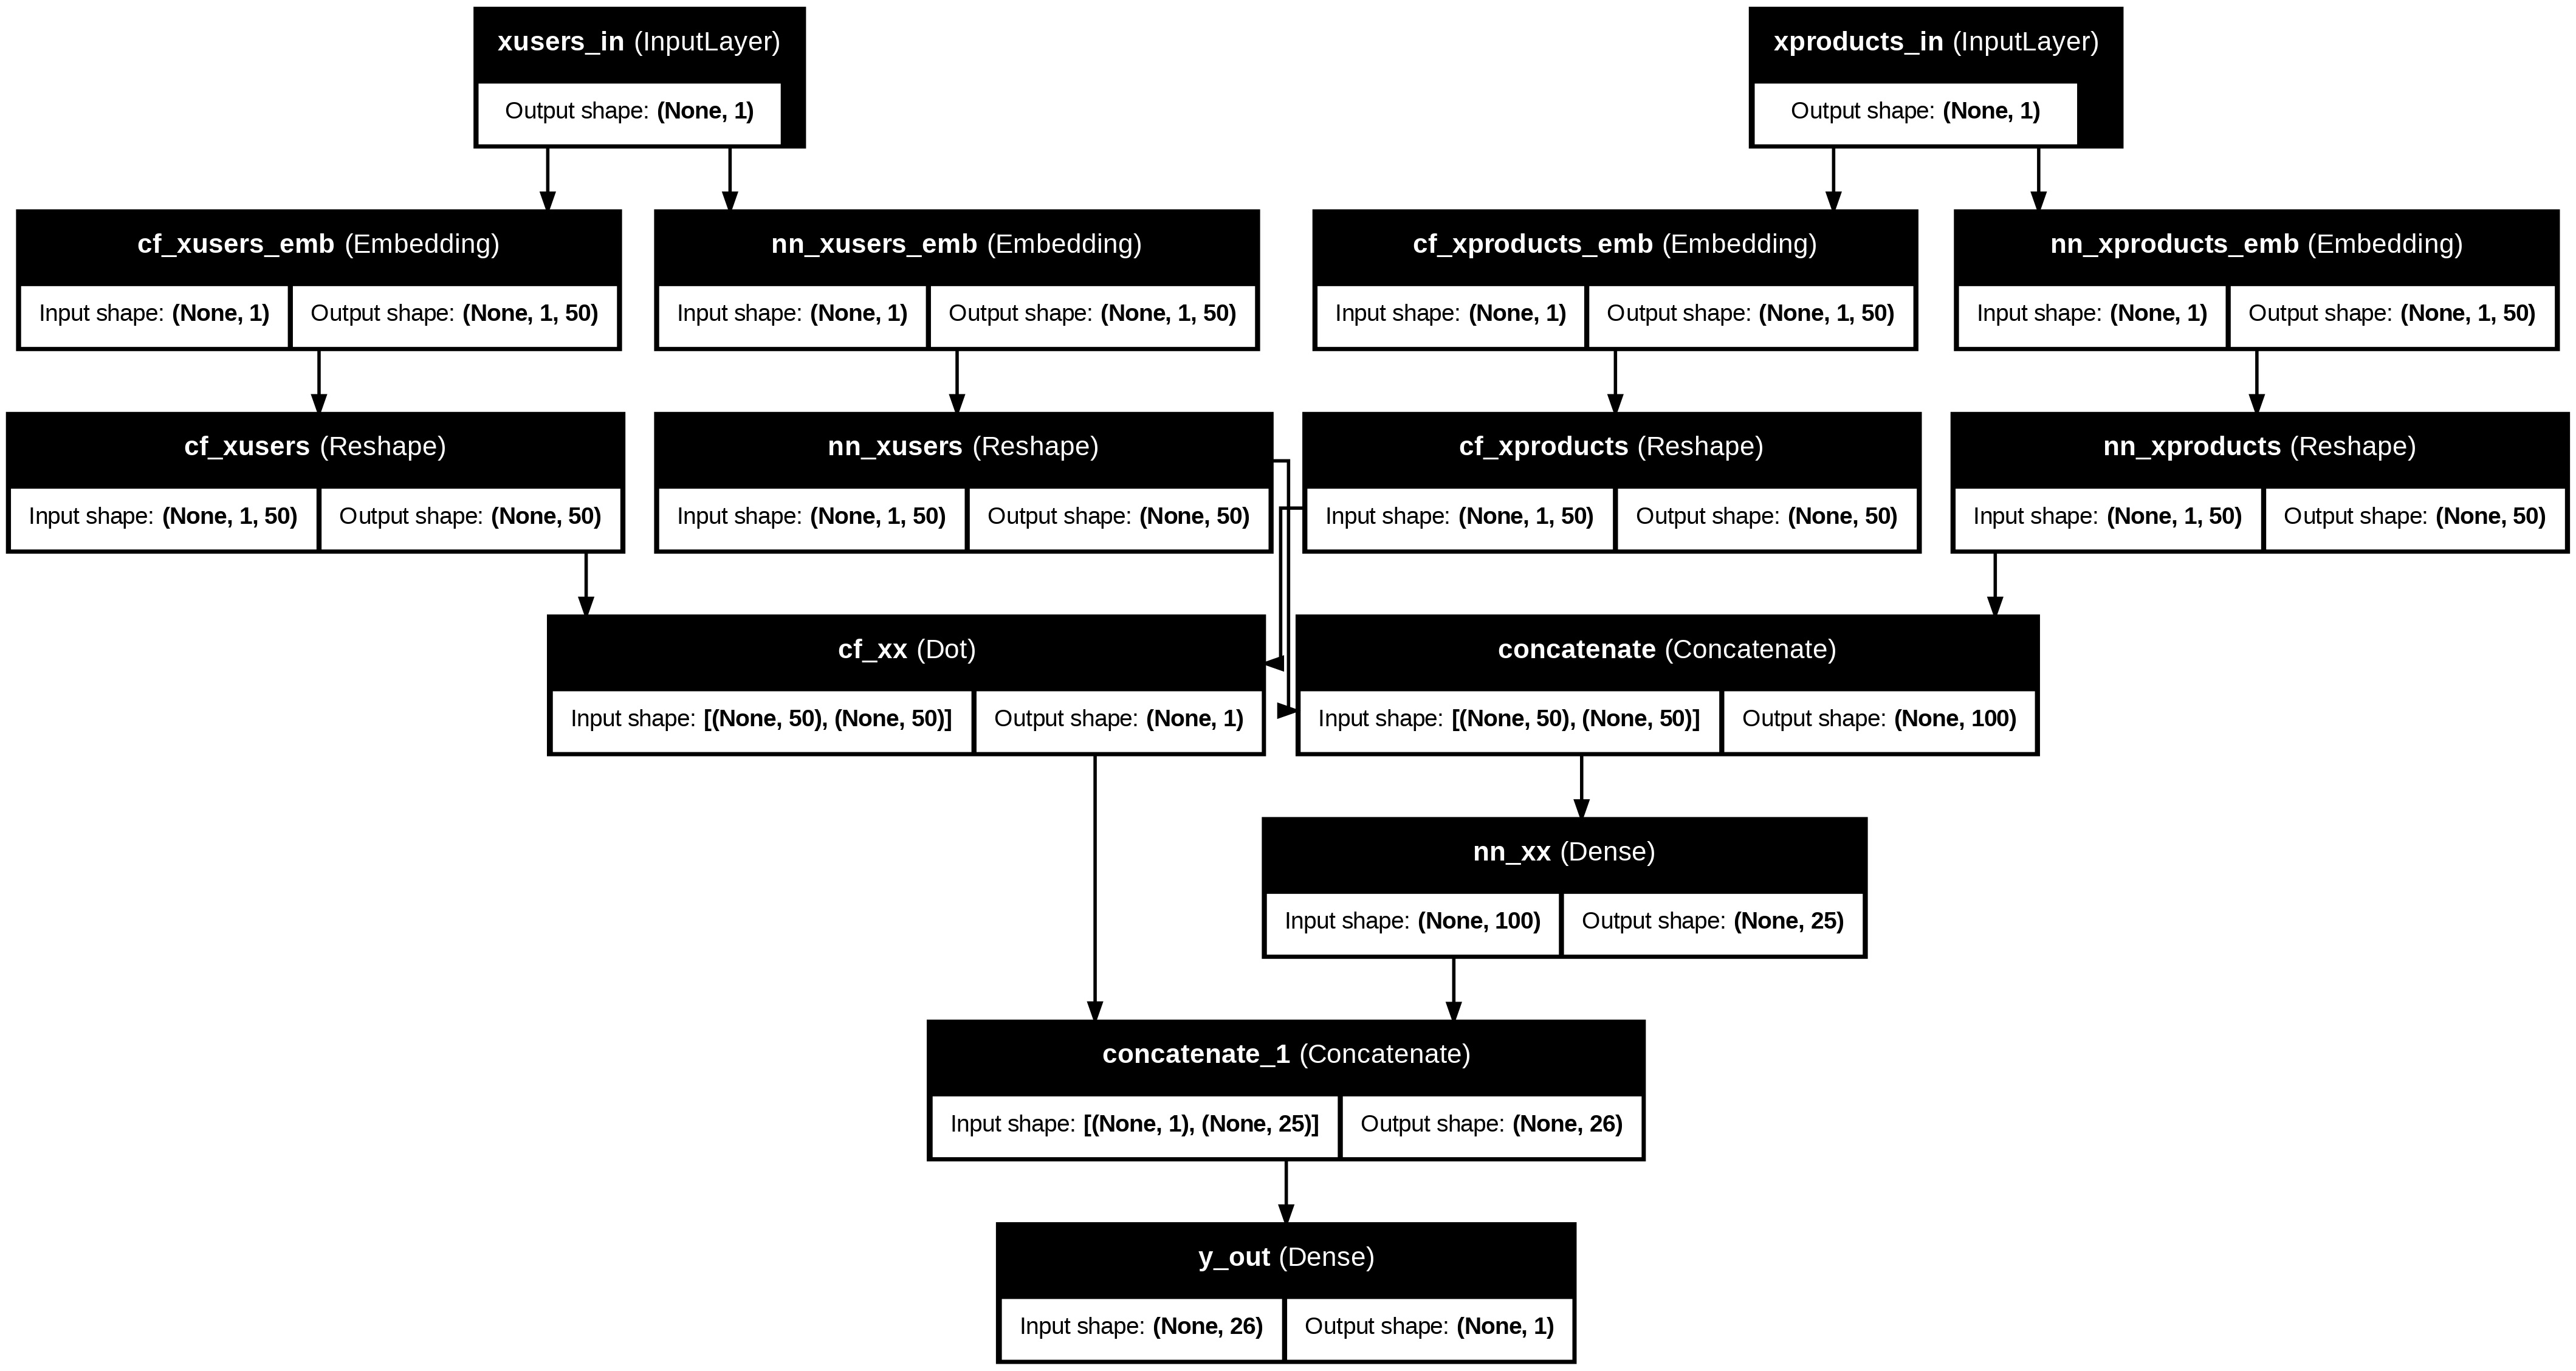

In [ ]:
utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

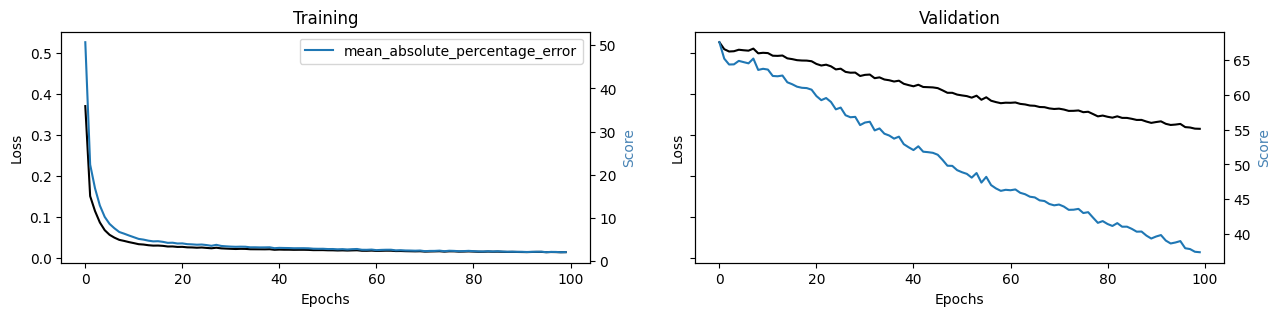

In [ ]:
# train
training = model.fit(x=[train["user"], train["product"]], y=train["y"],
                     epochs=100, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)
model = training.model
utils_plot_keras_training(training)

In [ ]:
# test
test["yhat"] = model.predict([test["user"], test["product"]])
test

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


,user,product,y,yhat
0,1,8063,0.812500,0.653472
1,1,8305,1.000000,0.767199
2,1,8376,0.777778,0.625640
3,1,8466,0.800000,0.645650
4,1,8509,0.500000,0.777761
...,...,...,...,...
666,64,8023,0.500000,0.445526
667,64,8376,0.944444,0.410714
668,64,8438,0.666667,0.427822
669,64,8569,0.900000,0.335722


In [ ]:
# overall
y_test = test["y"]
predicted = test["yhat"]

print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", str(round(np.mean(np.abs((y_test-predicted)/predicted)), 2))+"%")

Mean Absolute Error (Σ|y-pred|/n): 0
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.43%


In [ ]:
# single case
i = 1
print("--- user", i, "---")

top = 5
y_test = test[test["user"]==i].sort_values("y", ascending=False)["product"].values[:top]
print("y_test:", y_test)

predicted = test[test["user"]==i].sort_values("yhat", ascending=False)["product"].values[:top]
print("predicted:", predicted)

true_positive = len(list(set(y_test) & set(predicted)))
print("true positive:", true_positive, "("+str(round(true_positive/top*100,1))+"%)")
print("accuracy:", str(round(metrics.accuracy_score(y_test,predicted)*100,1))+"%")
print("mrr:", round(mean_reciprocal_rank(y_test, predicted),2))

--- user 1 ---
y_test: [8305 8681 8550 8063 8466]
predicted: [8509 8305 8828 8681 8550]
true positive: 3 (60.0%)
accuracy: 0.0%
mrr: 0.19


In [ ]:
test[test["user"]==i].merge(
        dtf_products[["name","old","genres"]], left_on="product", right_index=True
    ).sort_values("yhat", ascending=False)

,user,product,y,yhat,name,old,genres
4,1,8509,0.500000,0.777761,The Drop,0,Crime|Drama|Thriller
1,1,8305,1.000000,0.767199,"Wolf of Wall Street, The",0,Comedy|Crime|Drama
7,1,8828,0.500000,0.750249,The Jinx: The Life and Deaths of Robert Durst,0,Documentary
6,1,8681,1.000000,0.682987,Mad Max: Fury Road,0,Action|Adventure|Sci-Fi|Thriller
5,1,8550,0.875000,0.675630,Ex Machina,0,Drama|Sci-Fi|Thriller
0,1,8063,0.812500,0.653472,Django Unchained,0,Action|Drama|Western
3,1,8466,0.800000,0.645650,Whiplash,0,Drama
2,1,8376,0.777778,0.625640,Interstellar,0,Sci-Fi|IMAX


## Hybrid Model

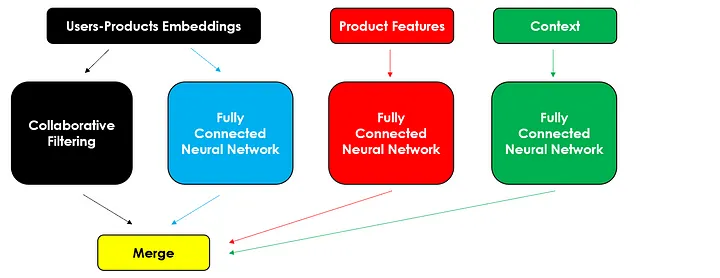

In [ ]:
# Extract data
features = dtf_products.drop(["genres","name"], axis=1).columns
print(features)

context = dtf_context.drop(["user","product"], axis=1).columns
print(context)

Index(['old', 'Western', 'Animation', 'Action', 'Thriller', 'Fantasy',
       'Adventure', 'Horror', 'War', 'Film-Noir', 'IMAX', 'Sci-Fi', 'Musical',
       'Crime', 'Romance', 'Drama', 'Mystery', 'Documentary', 'Comedy',
       'Children'],
      dtype='object')
Index(['daytime', 'weekend'], dtype='object')


In [ ]:
train = dtf_train.stack(dropna=True).reset_index().rename(columns={0:"y"})

## add features
train = train.merge(dtf_products[features], how="left", left_on="product", right_index=True)

## add context
train = train.merge(dtf_context, how="left")

train.head()

,user,product,y,old,Western,Animation,Action,Thriller,Fantasy,Adventure,...,Musical,Crime,Romance,Drama,Mystery,Documentary,Comedy,Children,daytime,weekend
0,0,0,0.80,1,0,1,0,0,1,1,...,0,0,0,0,0,0,1,1,1,1
1,0,2,0.75,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,1
2,0,5,0.75,1,0,0,1,1,0,0,...,0,1,0,0,0,0,0,0,1,1
3,0,43,1.00,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,1
4,0,46,1.00,1,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,1,1


In [ ]:
test = dtf_test.stack(dropna=True).reset_index().rename(columns={0:"y"})

## add features
test = test.merge(dtf_products.drop(["genres","name"], axis=1), how="left", left_on="product", right_index=True)

## add context
test[context] = 0 #--> simulate production for a weekday night
#test = test.merge(dtf_context, how="left") #--> use test set

test.head()

,user,product,y,old,Western,Animation,Action,Thriller,Fantasy,Adventure,...,Musical,Crime,Romance,Drama,Mystery,Documentary,Comedy,Children,daytime,weekend
0,1,8063,0.812500,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1,8305,1.000000,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
2,1,8376,0.777778,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,8466,0.800000,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1,8509,0.500000,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0


In [ ]:
# model design
embeddings_size = 50
usr, prd = dtf_users.shape[0], dtf_users.shape[1]
feat = len(features)
ctx = len(context)

########################################## COLLABORATIVE FILTERING ###################################################
# Input layer
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))

# A) Matrix Factorization
## embeddings and reshape
cf_xusers_emb = layers.Embedding(name="cf_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
cf_xusers = layers.Reshape(name='cf_xusers', target_shape=(embeddings_size,))(cf_xusers_emb)
## embeddings and reshape
cf_xproducts_emb = layers.Embedding(name="cf_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
cf_xproducts = layers.Reshape(name='cf_xproducts', target_shape=(embeddings_size,))(cf_xproducts_emb)
## product
cf_xx = layers.Dot(name='cf_xx', normalize=True, axes=1)([cf_xusers, cf_xproducts])

# B) Neural Network
## embeddings and reshape
nn_xusers_emb = layers.Embedding(name="nn_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
nn_xusers = layers.Reshape(name='nn_xusers', target_shape=(embeddings_size,))(nn_xusers_emb)
## embeddings and reshape
nn_xproducts_emb = layers.Embedding(name="nn_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
nn_xproducts = layers.Reshape(name='nn_xproducts', target_shape=(embeddings_size,))(nn_xproducts_emb)
## concat and dense
nn_xx = layers.Concatenate()([nn_xusers, nn_xproducts])
nn_xx = layers.Dense(name="nn_xx", units=int(embeddings_size/2), activation='relu')(nn_xx)

########################################## CONTENT BASED ###################################################
# Product Features
features_in = layers.Input(name="features_in", shape=(feat,))
features_x = layers.Dense(name="features_x", units=feat, activation='relu')(features_in)

########################################## KNOWLEDGE BASED #################################################
# Context
contexts_in = layers.Input(name="contexts_in", shape=(ctx,))
context_x = layers.Dense(name="context_x", units=ctx, activation='relu')(contexts_in)

########################################## OUTPUT ###################################################
# Merge all
y_out = layers.Concatenate()([cf_xx, nn_xx, features_x, context_x])
y_out = layers.Dense(name="y_out", units=1, activation='linear')(y_out)

# Compile
model = models.Model(inputs=[xusers_in,xproducts_in, features_in, contexts_in], outputs=y_out, name="Hybrid_Model")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
model.summary()

Model: "Hybrid_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ xusers_in (InputLayer)    │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ xproducts_in (InputLayer) │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ nn_xusers_emb (Embedding) │ (None, 1, 50)          │          3,300 │ xusers_in[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ nn_xproducts_emb          │ (None, 1, 50)          │        487,050 │ xproducts_in[0][0]     │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cf_xusers_emb (Embedding) │ (None, 1, 50)          │          3,300 │ xusers_in[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cf_xproducts_emb          │ (None, 1, 50)          │        487,050 │ xproducts_in[0][0]     │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ nn_xusers (Reshape)       │ (None, 50)             │              0 │ nn_xusers_emb[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ nn_xproducts (Reshape)    │ (None, 50)             │              0 │ nn_xproducts_emb[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cf_xusers (Reshape)       │ (None, 50)             │              0 │ cf_xusers_emb[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cf_xproducts (Reshape)    │ (None, 50)             │              0 │ cf_xproducts_emb[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 100)            │              0 │ nn_xusers[0][0],       │
│ (Concatenate)             │                        │                │ nn_xproducts[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ features_in (InputLayer)  │ (None, 20)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ contexts_in (InputLayer)  │ (None, 2)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cf_xx (Dot)               │ (None, 1)              │              0 │ cf_xusers[0][0],       │
│                           │                        │                │ cf_xproducts[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ nn_xx (Dense)             │ (None, 25)             │          2,525 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ features_x (Dense)        │ (None, 20)             │            420 │ features_in[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ context_x (Dense)         │ (None, 2)              │              6 │ contexts_in[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3        

 Total params: 983,700 (3.75 MB)

 Trainable params: 983,700 (3.75 MB)

 Non-trainable params: 0 (0.00 B)

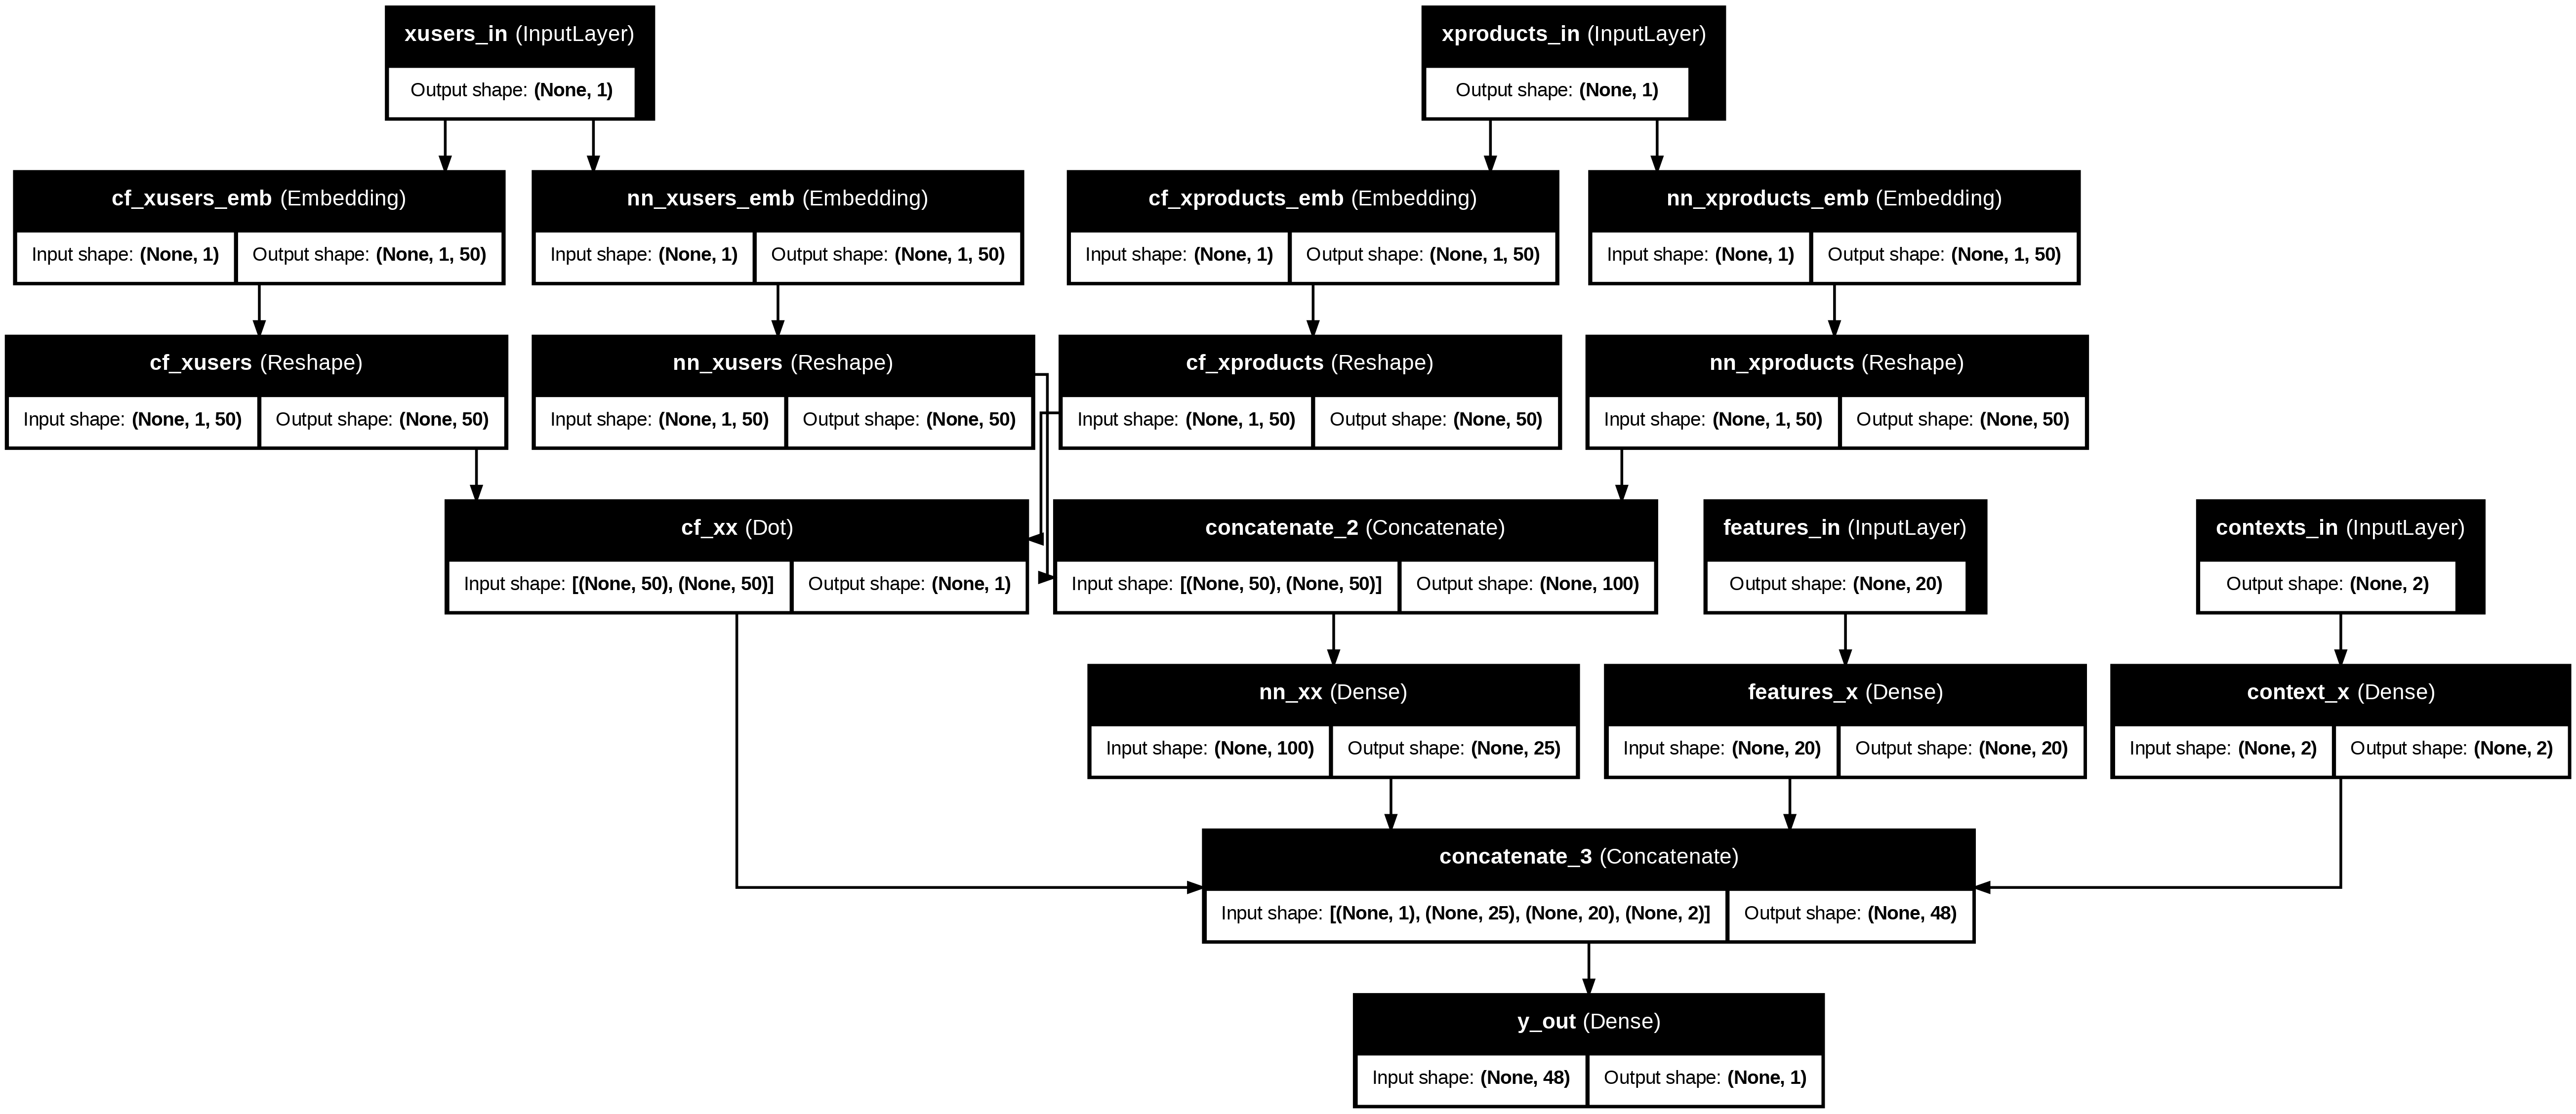

In [ ]:
utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# train
training = model.fit(x=[train["user"], train["product"], train[features], train[context]], y=train["y"],
                     epochs=100, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)

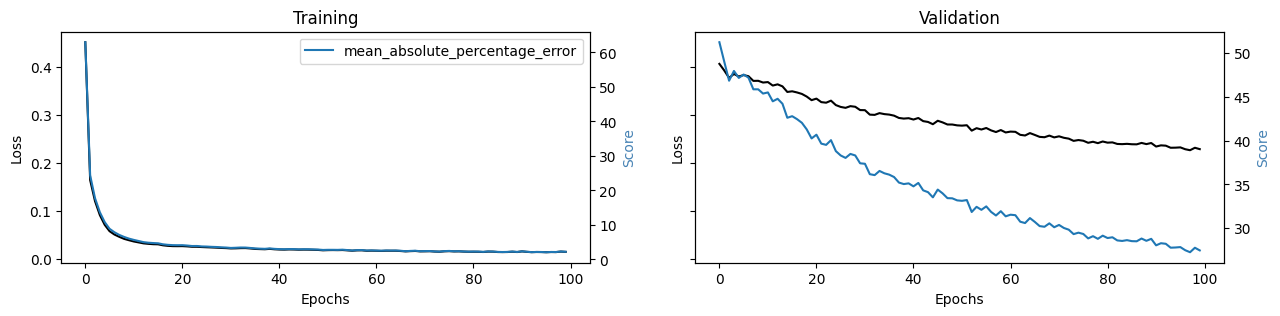

In [ ]:
model = training.model
utils_plot_keras_training(training)

In [ ]:
# test
test["yhat"] = model.predict([test["user"], test["product"], test[features], test[context]])
test

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


,user,product,y,old,Western,Animation,Action,Thriller,Fantasy,Adventure,...,Crime,Romance,Drama,Mystery,Documentary,Comedy,Children,daytime,weekend,yhat
0,1,8063,0.812500,0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0.588403
1,1,8305,1.000000,0,0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0.796570
2,1,8376,0.777778,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.694151
3,1,8466,0.800000,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0.585119
4,1,8509,0.500000,0,0,0,0,1,0,0,...,1,0,1,0,0,0,0,0,0,0.695402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,64,8023,0.500000,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0.524269
667,64,8376,0.944444,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.504483
668,64,8438,0.666667,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.493002
669,64,8569,0.900000,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0.360246


In [ ]:
# overall
y_test = test["y"]
predicted = test["yhat"]

print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", str(round(np.mean(np.abs((y_test-predicted)/predicted)), 2))+"%")

Mean Absolute Error (Σ|y-pred|/n): 0
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.33%


In [ ]:
# single case
i = 1
print("--- user", i, "---")

top = 5
y_test = test[test["user"]==i].sort_values("y", ascending=False)["product"].values[:top]
print("y_test:", y_test)

predicted = test[test["user"]==i].sort_values("yhat", ascending=False)["product"].values[:top]
print("predicted:", predicted)

true_positive = len(list(set(y_test) & set(predicted)))
print("true positive:", true_positive, "("+str(round(true_positive/top*100,1))+"%)")
print("accuracy:", str(round(metrics.accuracy_score(y_test,predicted)*100,1))+"%")
print("mrr:", round(mean_reciprocal_rank(y_test, predicted),2))

--- user 1 ---
y_test: [8305 8681 8550 8063 8466]
predicted: [8305 8681 8550 8509 8376]
true positive: 3 (60.0%)
accuracy: 60.0%
mrr: 0.37
